In [1]:
import glob
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import clima_anom as ca

import matplotlib.cbook
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import sys
sys.path.append('../../function/')
from Funciones import dbz2mm, mm2dbz

In [2]:
with open ('../../json/directories.json') as f:
    DIRS = json.load(f)

In [3]:
file_list = pd.read_csv(DIRS['dir_ENSEMBLE_list']+'TRMM_GPM_summer_200012_2021_02.csv')
len_files = len(file_list)
print(f'Files Number: {len_files}')
print(file_list['file_name'].iloc[0])
print(file_list['file_name'].iloc[-1])

Files Number: 63
/mnt/Data/Data/PF/TRMM/rpf_SA/rpf_200012_level2.csv
/mnt/Data/Data/PF/GPM/rgpf_SA/rgpf_202102_level2.csv


In [4]:
# data_input = '/mnt/Data/Data/PF/TRMM/rpf_SA/rpf_200101_level2.csv'
data = pd.read_csv(file_list['file_name'][35], sep=',')
data[data==-88.88] = np.nan
data[data==-99.99] = np.nan
data.head(10)

,lat,lon,YEAR,ORBIT,NPIXELS_20DBZ,NPIXELS_30DBZ,NPIXELS_40DBZ,NPIXELS_20MM,NPIXELS_30MM,NPIXELS_40MM,...,15.5,16.0,16.5,17.0,17.5,18.0,18.5,19.0,19.5,20.0
0,-33.710000,-80.83000,2012.0,80955.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-33.110000,-78.31000,2012.0,80955.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-33.730000,-69.98000,2012.0,80955.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-33.750000,-69.79000,2012.0,80955.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-33.390000,-69.73000,2012.0,80955.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-31.544167,-63.24083,2012.0,80955.0,24.0,7.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-30.570000,-62.30000,2012.0,80955.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-29.620000,-61.45000,2012.0,80955.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-30.134998,-60.38000,2012.0,80955.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-30.640000,-60.15000,2012.0,80955.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
levels = np.arange(0.5,20.5,0.5)

In [6]:
data_clear = data[data['NPIXELS_40MM']>0]
data_clear = data_clear.reset_index(drop=True)

In [7]:
PF_GPD = gpd.GeoDataFrame(data_clear[data_clear.columns[2:]], geometry=gpd.points_from_xy(data_clear['lon'],data_clear['lat'], crs="EPSG:4326"))

In [8]:
comm_GPD = gpd.read_file('/mnt/Data/Github/Complex-Network-AS/mapping/communities/Comm_IMERG_05x05_sync_summer_P90_tau3_SP95.shp')

In [9]:
num_comm = len(comm_GPD['geometry'])
num_points = len(PF_GPD['geometry'])

In [10]:
points_interception = []   

for t in range(num_points):

    if comm_GPD['geometry'][0].contains(PF_GPD['geometry'][t]) == True:
        points_interception.append(t)

dic_tmp = PF_GPD.loc[points_interception]
dic_tmp = dic_tmp.reset_index(drop=True)

print(f'Points in the community: {len(dic_tmp)}')

Points in the community: 211


In [11]:
salidaR = np.zeros((len(dic_tmp),40))

for n in range(len(dic_tmp)):
    tmp = dic_tmp.loc[n][27:-1].values
    salidaR[n,:] = dbz2mm(tmp)

In [12]:
R_mean = np.nanmean(salidaR, axis=0)
dbz_mean = mm2dbz(R_mean)
dbz_mean[dbz_mean<=0] = np.nan
dbz_mean.shape

/tmp/ipykernel_86155/118254583.py:1: RuntimeWarning: Mean of empty slice
  R_mean = np.nanmean(salidaR, axis=0)


(40,)

In [13]:
salidadbz = np.zeros_like(salidaR)
for n in range(len(salidaR)):
    salidadbz[n,:] = mm2dbz(salidaR[n,:])

salidadbz[salidadbz<=0] = np.nan
salidadbz.shape

(211, 40)

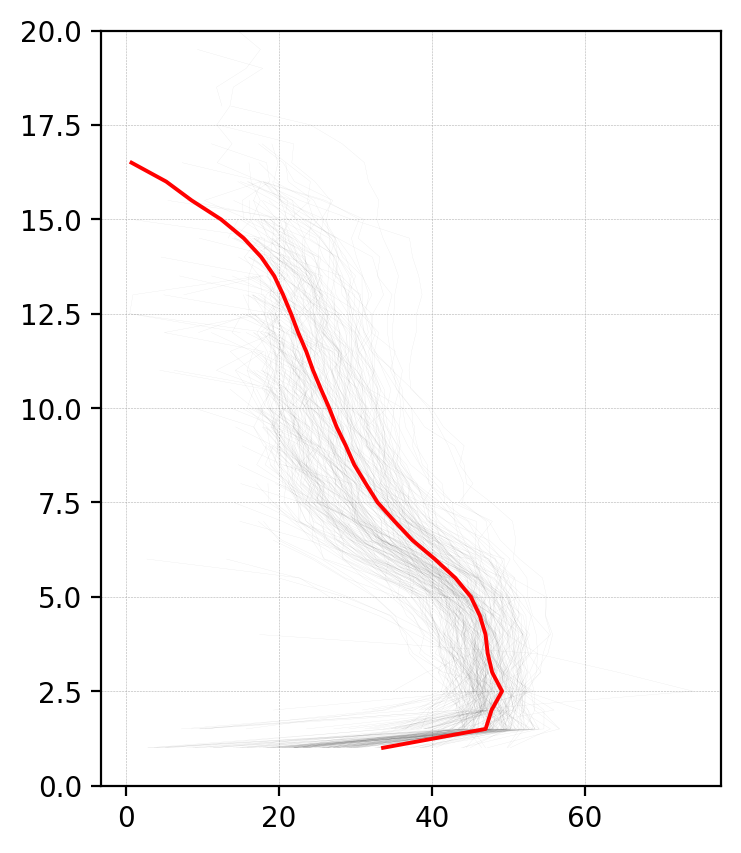

In [14]:
fig = plt.figure(figsize=(4,5),dpi=200)
for t in range(salidadbz.shape[0]):
    plt.plot(salidadbz[t,:],levels,linewidth=0.1,color='k',alpha=0.1)

plt.plot(dbz_mean,levels,linewidth=1.4,color='r')
plt.ylim(0,20)
plt.grid(linewidth=0.2,linestyle='--')